# Аналитик данных маркетплейса

In [3]:
# Подгрузка библиотек
import pandas as pd
import numpy as np
from datetime import datetime
from statistics import median
from operator import attrgetter
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors

In [4]:
# Подгрузка таблиц
olist_customers_dataset = pd.read_csv('olist_customers_dataset.csv')
olist_order_items_dataset = pd.read_csv('olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])
olist_orders_dataset = pd.read_csv('olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date'])

### Задача 1: Оценить месячный retention в оформление заказа с помощью когортного анализа.

In [5]:
rot = olist_orders_dataset.query("order_status == 'delivered'")
rot = pd.merge(rot, olist_customers_dataset, on='customer_id', how='left')

In [6]:
# Создание колонки со временем оформления первого доставленного клиента.
fst_orders_df = rot.groupby(['customer_unique_id'],as_index = False).agg({'order_purchase_timestamp':'min'})
fst_orders_df = fst_orders_df.rename(columns={'order_purchase_timestamp' : 'fst_order'})  

In [7]:
# Добавление колонки со временем оформления первого доставленного клиента в основной df.
rot = pd.merge(rot, fst_orders_df, on='customer_unique_id' ,how='left')

In [8]:
# Создание колонок когорты и колонки с количеством месяцев прошедших спустя оформления первого успешного заказа.
rot ['months_passed'] = np.floor((rot.order_purchase_timestamp - rot.fst_order).dt.days / 30)
rot ['cohort'] = rot.fst_order.dt.to_period("M")

In [9]:
# Определение количества успешных заказов в разбивке по когортам и месяцам прошедшим спустя оформления первого успешного заказа.
rot_tbl = rot.groupby(['cohort','months_passed'],as_index=False)['customer_unique_id'].nunique()
rot_tbl = rot_tbl.rename(columns={'customer_unique_id' : 'count_user'})  

In [10]:
# Определение количества клиента в нулевой день в разбивке по когортам. (Новые клиенты совершившие успешный заказ)
zero_day = rot_tbl.groupby(['cohort'],as_index=False).agg({'count_user':'max'})

In [11]:
# Добавление заказов нулевого дня
rot_tbl = pd.merge(rot_tbl, zero_day, on='cohort' ,how='left')

In [12]:
# Определение retention (доля)
rot_tbl['retention'] = round( rot_tbl.count_user_x/rot_tbl.count_user_y ,4)

In [13]:
# Определение retention (%)
rot_tbl['retention_prc'] = round( rot_tbl.count_user_x*100/rot_tbl.count_user_y ,4)

##### 1.1 Построить месячный retention.

In [14]:
# Месячный retention
rot_tbl_ch = rot_tbl.pivot(index='cohort', columns='months_passed', values='retention_prc')
ret_tbl_ch_dl = rot_tbl.pivot(index='cohort', columns='months_passed', values='retention')
ret_tbl_ch_dl

months_passed,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.0038,NaN,NaN,0.0038,...,0.0038,NaN,0.0038,NaN,0.0038,NaN,0.0038,0.0076,0.0038,0.0038
2016-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.0028,NaN,0.0056,0.0014,0.0014,0.0028,0.0028,NaN,NaN,...,0.0056,0.0042,0.0028,NaN,0.0028,0.0028,0.0028,0.0014,NaN,NaN
2017-02,1.0,0.0012,0.0018,0.0037,0.0025,0.0012,0.0025,0.0006,0.0012,0.0031,...,0.0037,0.0006,0.0018,0.0012,0.0006,0.0006,0.0018,NaN,NaN,NaN
2017-03,1.0,0.0028,0.0052,0.0044,0.0012,0.0008,0.0036,0.0016,0.0028,0.0024,...,0.0016,0.0016,0.0012,0.0028,0.0008,0.0012,0.0008,NaN,NaN,NaN
2017-04,1.0,0.0035,0.0027,0.0004,0.0027,0.0035,0.0027,0.0044,0.0027,0.0022,...,0.0013,NaN,0.0009,0.0009,0.0009,0.0009,NaN,NaN,NaN,NaN
2017-05,1.0,0.0043,0.0038,0.0023,0.0038,0.0032,0.0032,0.0012,0.0029,0.0026,...,0.0032,0.0017,0.0009,0.0020,0.0012,NaN,NaN,NaN,NaN,NaN
2017-06,1.0,0.0043,0.0053,0.0033,0.0020,0.0049,0.0030,0.0020,0.0013,0.0033,...,0.0026,0.0010,0.0030,0.0013,NaN,NaN,NaN,NaN,NaN,NaN


#### 1.2 Чему равен медианный retention за первый месяц? Ответ укажите в виде доли и с 4 знаками после запятой.

In [15]:
# Медианный retention за первый месяц.
med_ret = median(rot_tbl.pivot(index='cohort', columns='months_passed', values='retention')[1]) #0.0035 
med_ret

0.0035

#### 1.3 Найти когорту с самым высоким retention на 3-й месяц.

In [16]:
# Когорта с самым высоким retention на 3-й месяц.
ret_tbl_ch_dl[3].sort_values(ascending=False).head(1) #2017-01    0.0056

cohort
2017-01    0.0056
Freq: M, Name: 3.0, dtype: float64

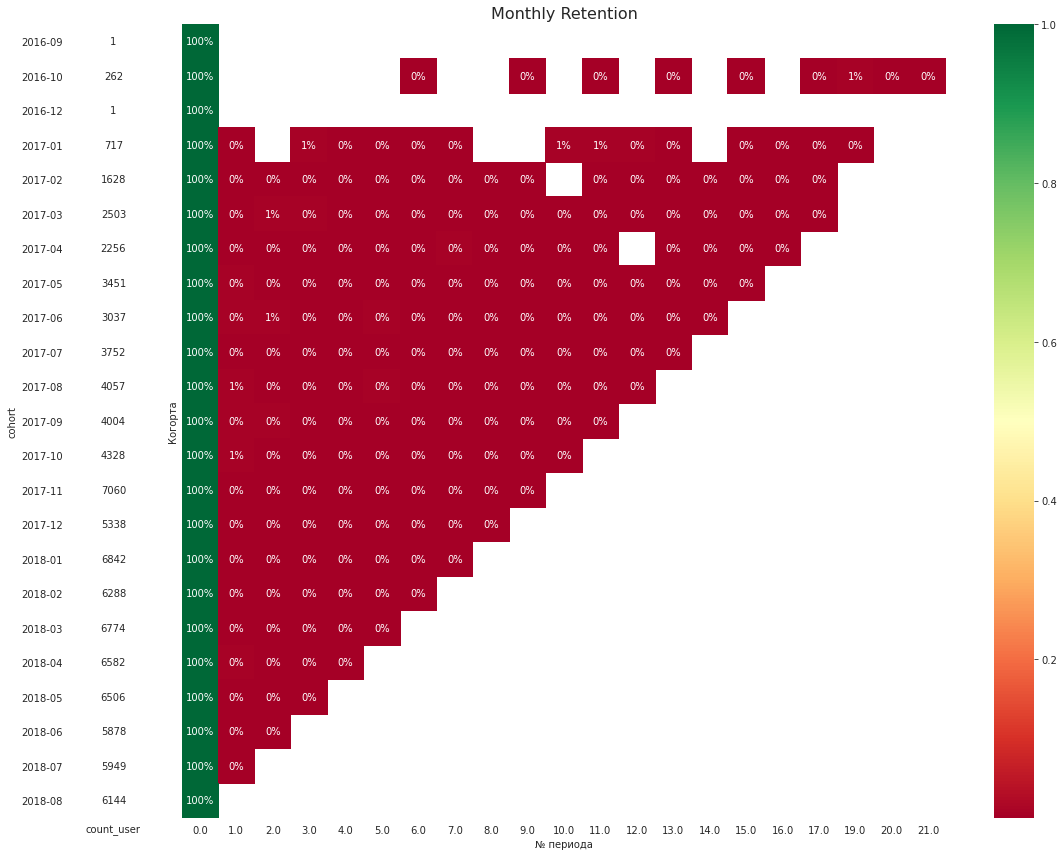

In [17]:
# Построение тепловой карты

#Изменение индекса
zero_day.set_index('cohort', inplace=True)

# Рассчитываем размеры когорт (первый столбец сводной таблицы)
cohort_size = rot_tbl_ch.iloc[:, 0]

# Вычисляем коэффициенты удержания, деля на размер когорты
retention_matrix = rot_tbl_ch.divide(cohort_size, axis=0)
# Строим тепловую карту когортного анализа
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # Тепловая карта для коэффициентов удержания
    sns.heatmap(retention_matrix,
                mask=retention_matrix.isnull(),
                annot=True,
                fmt='.0%',
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title('Monthly Retention', fontsize=16)
    ax[1].set(xlabel='№ периода', ylabel='Когорта')

    # Тепловая карта для размеров когорт
    cohort_size_df = zero_day
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])

    fig.tight_layout()
    plt.show()

#### Вывод: 
Заявленная проблема - прекращение роста выручки. Во всех когортах почти одинаково низкий retention (меньше 1%). 

### Задача 2: Определить, существует ли product/market fit у этого маркетплейса.

#### 2.1 Оценка product/market fit.

In [18]:
rot ["month_create"] = rot.order_purchase_timestamp.dt.to_period("M")

In [19]:
rot ['month_first_create'] = rot.fst_order.dt.to_period("M")

In [20]:
# Расчет общего retention
all_retention = rot_tbl.groupby('months_passed').agg({'count_user_y':'sum', 'count_user_x':'sum'  })
all_retention ['retention'] = round(all_retention['count_user_x']/all_retention['count_user_y'],4)
all_retention = all_retention.reset_index()
all_retention ['retention_pct'] = round(all_retention ['retention'] * 100,2)

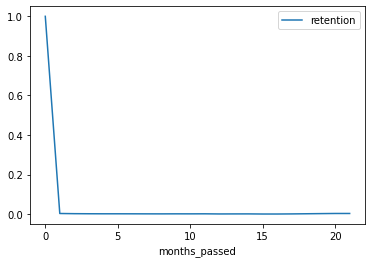

In [21]:
all_retention.plot(x="months_passed",y="retention")

In [22]:
#Объединение всех таблиц
all_info =  pd.merge(olist_orders_dataset,  olist_customers_dataset, on='customer_id' ,how='left')
all_info =  pd.merge(all_info,  olist_order_items_dataset, on='order_id' ,how='left')
all_info ['month_order_purchase_timestamp'] = all_info['order_purchase_timestamp'].dt.to_period("M")
all_fst = all_info.groupby(['customer_unique_id'],as_index = False).agg({'order_purchase_timestamp':'min'})
all_info = pd.merge(all_info, all_fst, on='customer_unique_id', how='left')
all_info ['months_passed'] = np.floor((all_info.order_purchase_timestamp_x - all_info.order_purchase_timestamp_y).dt.days / 30)

#### 2.2 Возможные причины.

In [23]:
# Клиентов не устроило время доставки?
((olist_orders_dataset['order_delivered_carrier_date'] - olist_orders_dataset['order_purchase_timestamp']).dt.days > 5).sum()*100/olist_orders_dataset['order_id'].count()
# Возможно. У более чем 11% заказов время доставки составило более 5 дней при 2-3 днях в среднем.

11.838175400488732

In [24]:
# Есть проблемы с подтвеждением оплаты?
((olist_orders_dataset['order_approved_at'] - olist_orders_dataset['order_purchase_timestamp']).dt.days > 0).sum()*100/olist_orders_dataset['order_id'].count()
# Возможно. У более чем 17% заказов время подтверждения оплаты составило 1 и более дней.

17.5179252018785

#### Вывод: 
Product/market fit отсутствует так как  retention стремится к нулю и не выходит на плато. В большенстве своем клиенты не возвращаются после первого заказа. Возможно клиенты были недовольны сроками доставки и получив плохой пользовательский опыт решили не возвращаться в продукт. Возможно есть проблемы с системой оплаты столкнувшись с которыми клиенты также решили не возвращаться в продукт.

### Задача 3: Определить 5 основных метрик, на которых продакту можно сконцентрироваться, чтобы максимизировать прибыль компании.

#### 3.1 Первая метрика должна отражать рост объёма продаж маркетплейса. Выручка (Revenue).

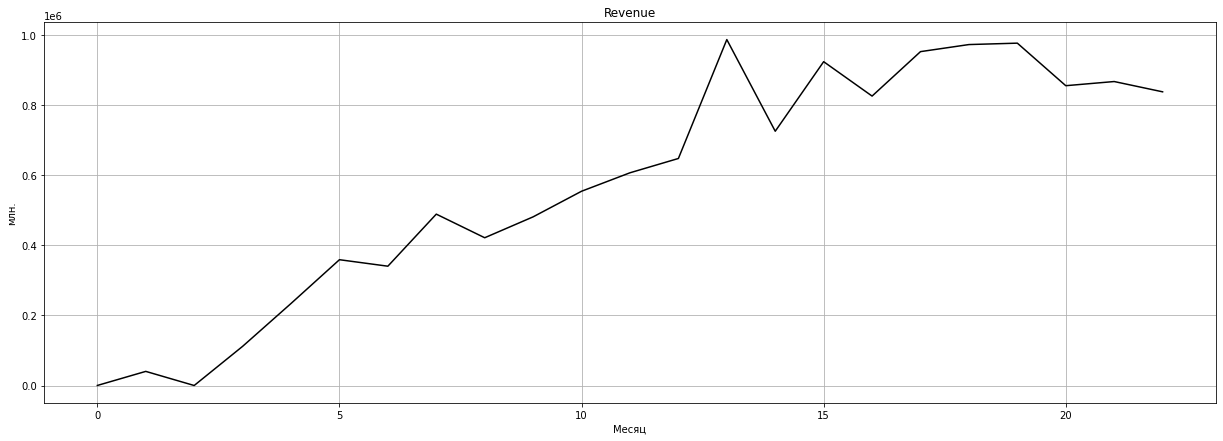

In [25]:
# Расчет выручки (Revenue)
all_info.query("order_status == 'delivered'").groupby('month_order_purchase_timestamp',as_index = False).agg({'price':'sum'}).plot( figsize=(21,7), legend=False, color='black')

plt.title('Revenue')
plt.xlabel('Месяц')
plt.ylabel('млн.')
plt.grid()
plt.show()

#### 3.2 Вторая метрика — показывать объем аудитории, которой продукт доставляет ценность. MAU (кол-во активных платящих клиентов).

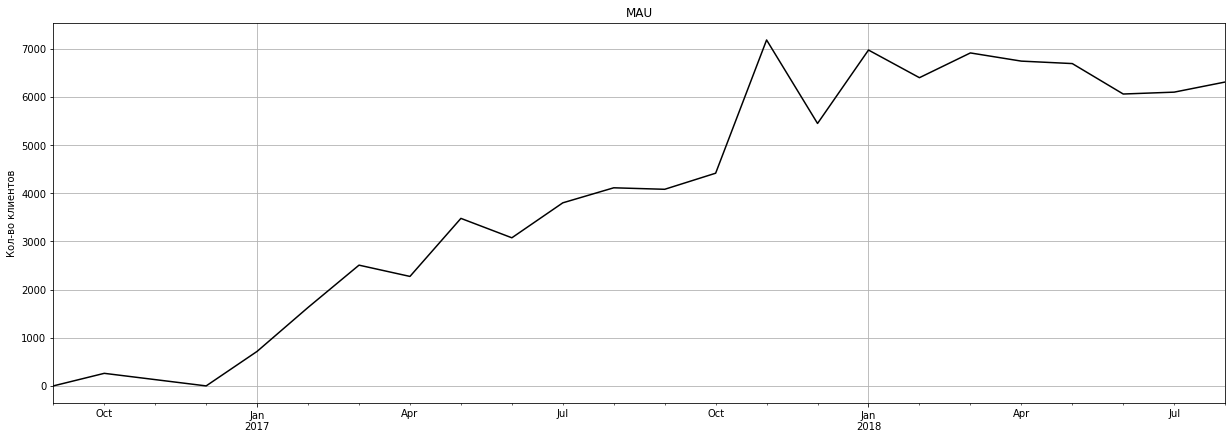

In [26]:
# Расчет MAU (кол-во активных платящих клиентов)
all_info.query("order_status == 'delivered'").groupby('month_order_purchase_timestamp')['customer_unique_id'].nunique().plot(figsize=(21,7), legend=False, color='black') 

plt.title('MAU')
plt.xlabel('')
plt.ylabel('Кол-во клиентов')
plt.grid()
plt.show()

#### 3.3 Третья метрика — отражать заинтересованность новых клиентов в продакте. Коэффициент конверсии (Conversion Rate).

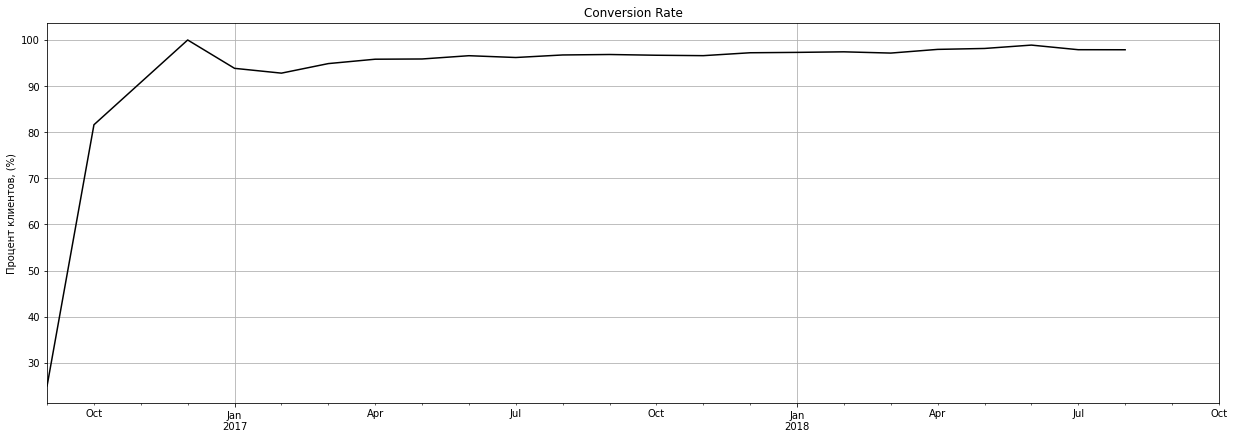

In [27]:
# Расчет коэффициента конверсии (Conversion Rate)
round(all_info.query("order_status == 'delivered' and order_purchase_timestamp_x == order_purchase_timestamp_y").groupby('month_order_purchase_timestamp')['customer_unique_id'].nunique()*100/all_info.query("order_purchase_timestamp_x == order_purchase_timestamp_y").groupby('month_order_purchase_timestamp')['customer_unique_id'].nunique(),2).plot(figsize=(21,7), legend=False, color='black')
plt.title('Conversion Rate')
plt.xlabel('')
plt.ylabel('Процент клиентов, (%)')
plt.grid()
plt.show()

#### 3.4 Четвёртая метрика — отражать вовлеченность клиента в продолжение использования продукта. Коэффициент удержания (Retention Rate).

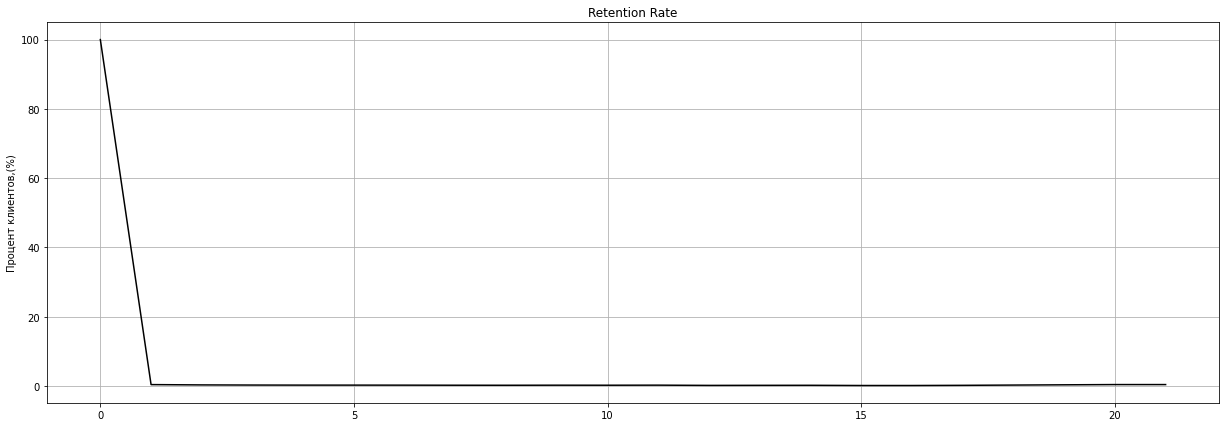

In [28]:
# Расчет коэффициента удержания (Retention Rate)
all_retention.plot(x="months_passed", y="retention_pct",figsize=(21,7), legend=False, color='black')
plt.title('Retention Rate')
plt.xlabel('')
plt.ylabel('Процент клиентов,(%)')
plt.grid()
plt.show() 

#### 3.5 Пятая метрика — отражать денежное выражение вовлеченности клиента. Средний доход на пользователя (Average Revenue Per User - ARPU).

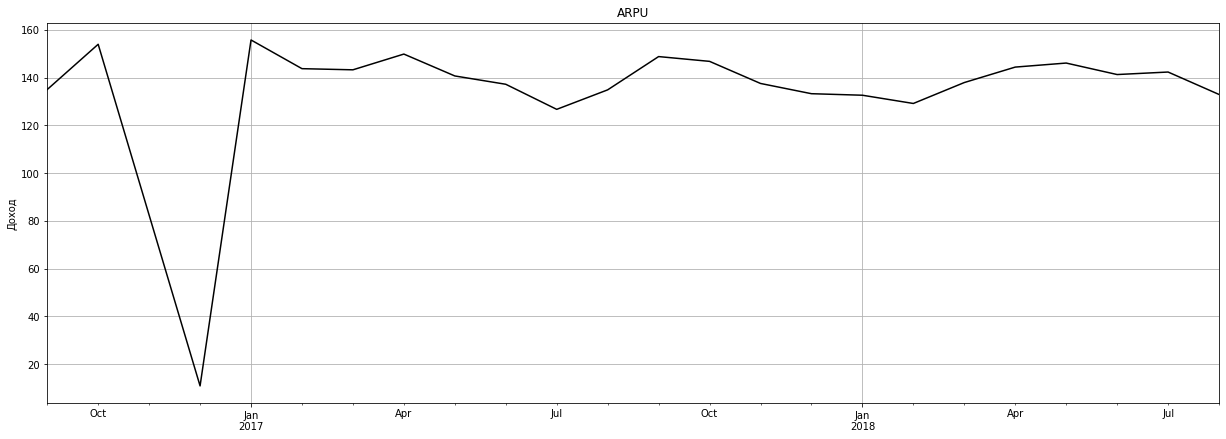

In [29]:
# Расчет среднего дохода на пользователя (Average Revenue Per User - ARPU)
round(all_info.query("order_status == 'delivered'").groupby('month_order_purchase_timestamp')['price'].sum() /all_info.query("order_status == 'delivered'").groupby('month_order_purchase_timestamp')['customer_unique_id'].nunique(),2).plot(figsize=(21,7), legend=False, color='black')
plt.title('ARPU')
plt.xlabel('')
plt.ylabel('Доход')
plt.grid()
plt.show() 

#### Вывод: 
Так как у нас почти отсутствует retention, но при этом сonversion среди новых клиентов очень высокий, то получается, что основная часть выручки формируется из заказов первичных клиентов. Так как после скачкообразного прироста новых клиентов в 2017-11 их колличество стало сокращаться выручка также стала сокращаться. Размер среднего чека значительно не изменялся.

### Задача 4: Выбрать одну из 3 основных гипотез с помощью фреймворка ICE.

In [30]:
# По условию необходимо использовать данные с 2017.06
order_2017_06 = all_info.query("order_purchase_timestamp_x >= '2017-06-01 00:00:00'")

In [31]:
# Функция для расчета impact
def definition_impact (x):
    impact =    [[[1],[list(range(51))]],
                [[2],[list(range(51,151))]],
                [[3],[list(range(151,351))]],
                [[4],[list(range(351,751))]],
                [[5],[list(range(751,1550))]],
                [[6],[list(range(1551,1351))]],
                [[7],[list(range(3151,6351))]],
                [[8],[list(range(6351,12751))]],
                [[9],[list(range(12751,25551))]],
                [[10],[list(range(25551,51151))]]]
    for i in impact:       
        if x in i[1][0]:
            return i[0][0]          

#### Гипотеза 1
Если исправим баг в системе процессинга заказов, то клиентам не придётся сталкиваться с проблемой отмены заказа, вследствие чего количество доставленных заказов увеличится. Считаем, что мы таким образом избавимся от всех отмен.

In [32]:
# Рачет кол-ва всех отмененных заказов за период.
impact_1 = definition_impact (order_2017_06.query("order_status == 'canceled'")['order_id'].nunique()) 
impact_1

4

In [33]:
# ICE - 1
ice_1 = impact_1*8*6
ice_1 

192

####  Гипотеза 2
Если сократим время до отгрузки заказа, то клиенты перестанут получать свой заказ с запаздыванием, вследствие чего количество заказов увеличится за счёт повторных заказов. Считаем, что мы таким образом избавимся от всех отмен.

In [34]:
# Рачет кол-ва отмененных повторных заказов за период.
impact_2 = definition_impact (order_2017_06.query("order_status == 'canceled' and order_purchase_timestamp_x != order_purchase_timestamp_y")['order_id'].nunique())
impact_2 

2

In [35]:
# ICE - 2
ice_2 = impact_2*10*4
ice_2

80

####  Гипотеза 3
Если создадим новый способ оплаты, который будет конвертировать клиентов в повторный заказ, то клиенты не будут испытывать трудности при оформлении заказа, вследствие чего количество заказов увеличится за счёт повторных заказов.

In [36]:
# Расчет кол-ва клиентов делавших успешные заказы за период.
all_client = order_2017_06.query("order_status == 'delivered'")['customer_unique_id'].nunique()
impact_3 = definition_impact (round(all_client * med_ret))
impact_3

3

In [37]:
# ICE - 3
ice_3 = impact_3*5*9
ice_3

135

In [38]:
# Определение максимального ICE
answer = {ice_1 : 'ice_1', ice_2 : 'ice_2', ice_3 : 'ice_3'}
answer.get(max(list(answer.keys())))

'ice_1'

#### Вывод: 
После расчета ICE можно прийдти к выводу что 1я гипотиза более приоритетная для проверки. 

### Задача 5: Сформулировать нужные метрики, на которые ваша гипотеза должна повлиять.

<p><b>ЦЕЛЕВЫЕ:</b> кол-во отмененных заказов</p>
<p><b>ПРОКСИ:</b> доля отмененных заказов</p>
<p><b>GURDRAIL:</b> ARPU, MAU</p>

#### Вывод:
Для контроля тестирования гипотизы наиболее удобно будет использовать вышеуказанные метрики. Также изменения должны повлиять на Conversion, Revenue и в болеее меньшей степени на Retention.

#### Выводы по итогу исследования:

В рамках исследования был выполнен анализ данных с целью выявления причин снижения роста выручки. Результаты показали, что из-за низкого retention существует сильная корреляция между выручкой и притоком новых клиентов. При помощи ICE для дальнейшего анализа была отобрана гипотеза и подобраны метрики позволяющие наиболее полно зафиксировать проводимые изменения.

In [39]:
# Доля отмененных заказов
all_info.query("order_status == 'canceled'")['order_id'].nunique()*100/all_info['order_id'].nunique() #  % отмененных заказов

0.6285133898492573

#### Рекомендации по продукту

Так как доля отмененных заказов (0,63%) в общей массе не столь велика, то даже в случае успешного подтверждения гипотезы A/B тестом и последующим ее внедрением основные метрики не вырастут значительно. Требуется разрабатывать новые гипотезы предполагающие повышение retention.